## ECE495 Hana's Hiragana Spiking Neural Network

#### Import tools

We first need to make sure we download all of our supporting libraries we will need. (Nengo, NengoDL, TensorFlow)
  

In [32]:
from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

## Load the data

 


We will use the data from Kuzushi-49 which has 49 classes which represent the 49 hiragana characters. 

c:\Users\C25Hana.Hill\495\495\mapping_algos\.venv\lib\site-packages\nengo_dl\simulator.py:2066: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x256d2174ca0>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  warnings.warn(


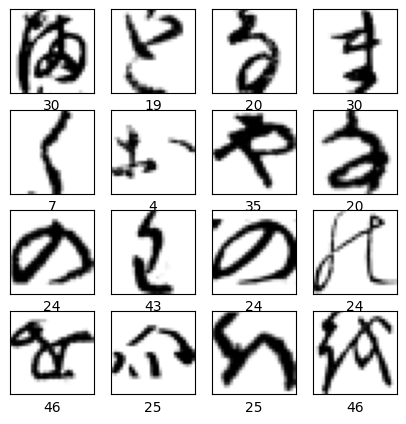

In [33]:
# Load data from NPZ files
train_images_data = np.load("C:/Users/C25Hana.Hill/495/495/Final_Project_495/k49-train-imgs.npz")
train_labels_data = np.load("C:/Users/C25Hana.Hill/495/495/Final_Project_495/k49-train-labels.npz")
test_images_data = np.load("C:/Users/C25Hana.Hill/495/495/Final_Project_495/k49-test-imgs.npz")
test_labels_data = np.load("C:/Users/C25Hana.Hill/495/495/Final_Project_495/k49-test-labels.npz")

# Access individual arrays within the NPZ files
#---using 'arr_0' because this is the "Key" to the arrays we loaded in . 
train_images = train_images_data['arr_0']
train_labels = train_labels_data['arr_0']
test_images = test_images_data['arr_0']
test_labels = test_labels_data['arr_0']

#We no longer need to normalize the data like we had to when we used a DNN

# Make sure our data looks proper
plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

# Next we need to Flatten your Images so we will 'reshape'
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

In [34]:
# because we are now spiking data we need to use TIME. 
n_steps = 40
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))


# Add the single timestep to the training data to ensure dimensions match
train_images = train_images[:, None, :]  # , (1, 1, 1))
train_labels = train_labels[:, None, None]  # , (1, 1, 1))

Next we are going to train our SNN.

### Building the Layers

Here is what we want our layers to do. 
1. Dense
2. Dropout
3. Dense

In [35]:
with nengo.Network(seed=0) as net:
    # NengoDL default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)
    nengo_dl.configure_settings(stateful=False)

    # This is the input node that will be used to rate encode in input images (i.e. our Flatten layer from ICE1)
    inp = nengo.Node(
        np.zeros(train_images.shape[2])
    )  ### changed from 1 to 2 bc it was in wrong????

    # First dense layer
    a = nengo_dl.Layer(
        tf.keras.layers.Dense(units=128, activation="relu", name="dense1_layer")
    )(inp)
    a = nengo_dl.Layer(neuron_type)(a)

    # Dropout layer
    b = nengo_dl.Layer(tf.keras.layers.Dropout(0.2, name="dropout_layer"))(a)
    b = nengo_dl.Layer(neuron_type)(b)

    # Final dense layer
    #MAKE SURE THE UNITS MATCH NUMBER OF HIRAGANA CLASSES WHICH IS 49
    out = nengo_dl.Layer(
        tf.keras.layers.Dense(units=49, activation="relu", name="dense1_layer")
    )(b)

    # Here we create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

Next we need to compile our model. 

In [36]:
minibatch_size = 256
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

|                     Building network (0%)                    | ETA:  --:--:--
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
| #                       Constructing graph                          | 0:00:00


c:\Users\C25Hana.Hill\495\495\mapping_algos\.venv\lib\site-packages\nengo_dl\simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##############Constructing graph: build stage (26%)             | ETA: 0:00:00
|##############Constructing graph: build stage (60%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|   #                     Constructing graph                          | 0:00:00
Constructing graph: build stage finished in 0:00:00
Construction finished in 0:00:00


In [37]:
# Custom loss function for testing
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# Compile for training
sim.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    },  ##### using out_p bc this is training.
    metrics=[tf.metrics.SparseCategoricalAccuracy()],  # ["accuracy"]
)

c:\Users\C25Hana.Hill\495\495\mapping_algos\.venv\lib\site-packages\nengo_dl\simulator.py:1736: UserWarning: Number of elements (1) in ['SparseCategoricalAccuracy'] does not match number of Probes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


## Next we TRAIN our model


In [38]:
sim.fit(train_images, {out_p: train_labels}, epochs=5)

Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##############Constructing graph: build stage (26%)             | ETA: 0:00:00
|##############Constructing graph: build stage (60%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##############Constructing graph: build stage (26%)             | ETA: 0:00:00
|##############Constructing graph: build stage (60%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build 

Next we will see our ACCURACY

In [43]:
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(
        test_images[0 : 256 * 3], {out_p_filt: test_labels[0 : 256 * 3]}, verbose=0
    )["loss"],
    # sim.evaluate(test_images, {???: test_labels}, verbose=0)["loss"],
)

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##############Constructing graph: build stage (26%)             | ETA: 0:00:00
|##############Constructing graph: build stage (73%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##############Constructing graph: build stage (26%)             | ETA: 0:00:00
|##############Constructing graph: build stage (86%)####         | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage fini

Accuracy after training: 0.5807291865348816


## Predictions

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############  Constructing graph: build stage (20%)             | ETA: 0:00:00
|##############Constructing graph: build stage (60%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
1/1 [==============================] - 1s 1s/step


C:\Users\C25Hana.Hill\AppData\Local\Temp\ipykernel_25868\386474190.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


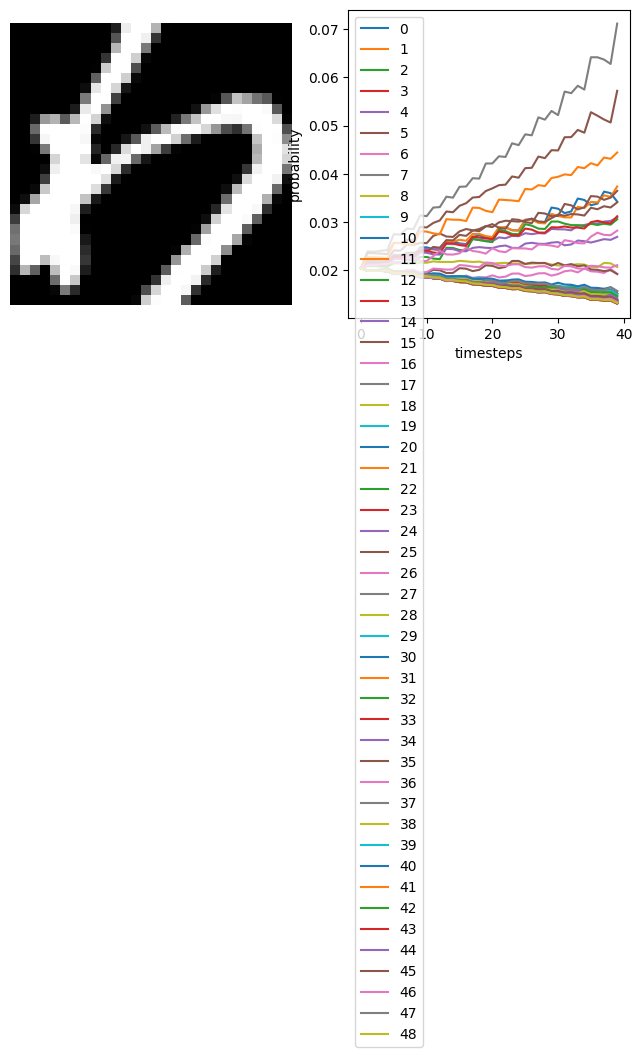

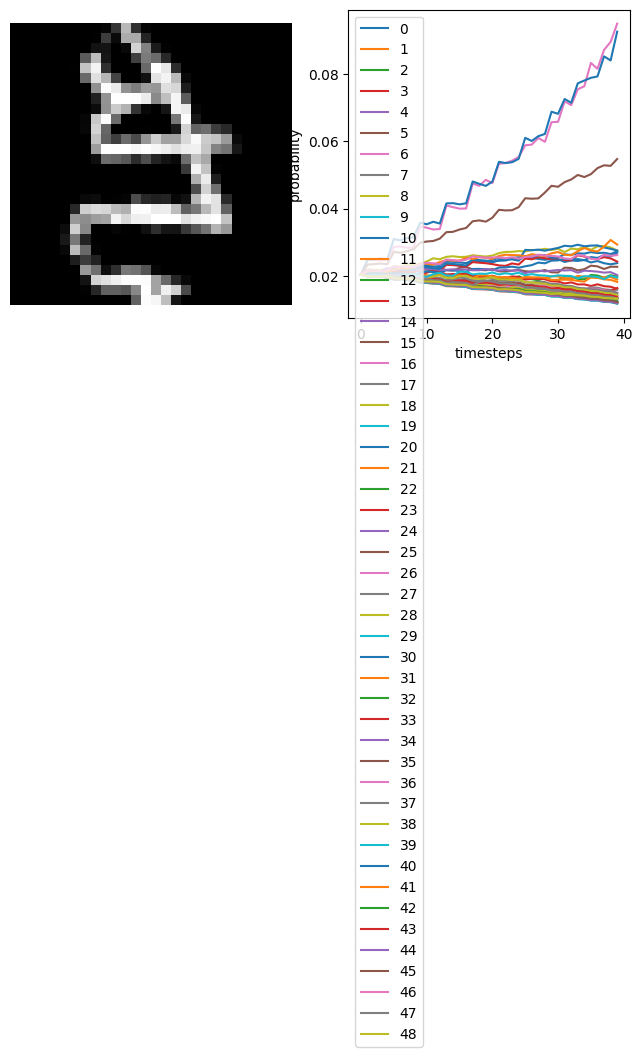

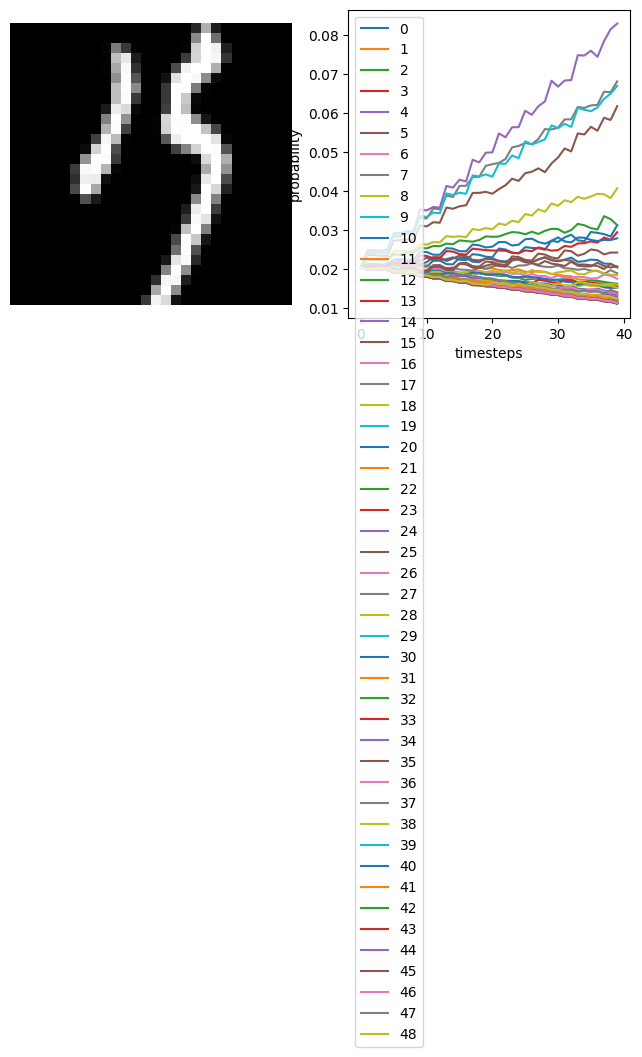

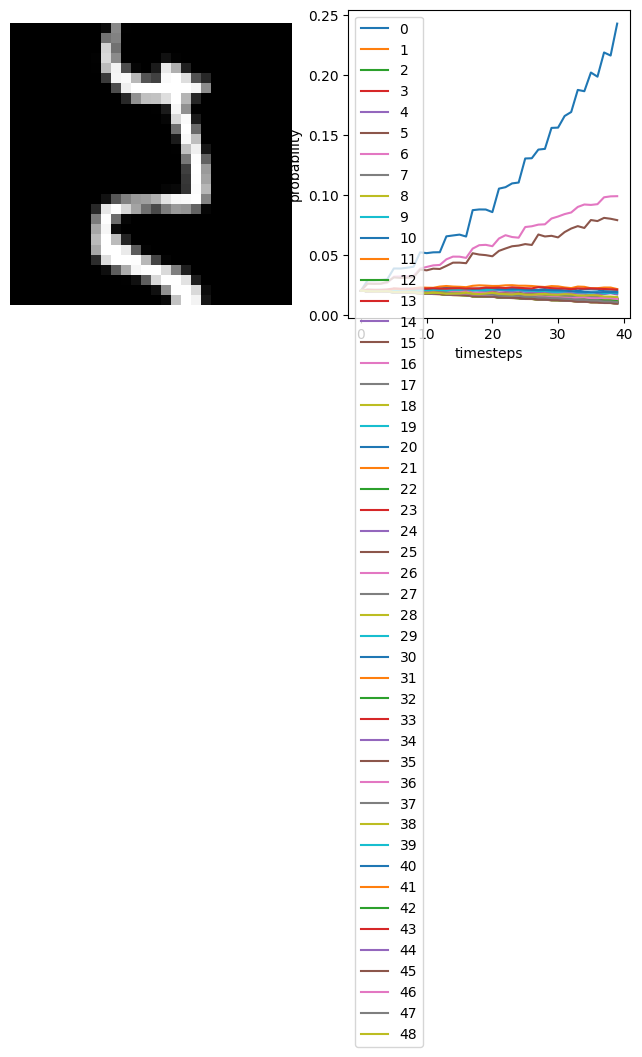

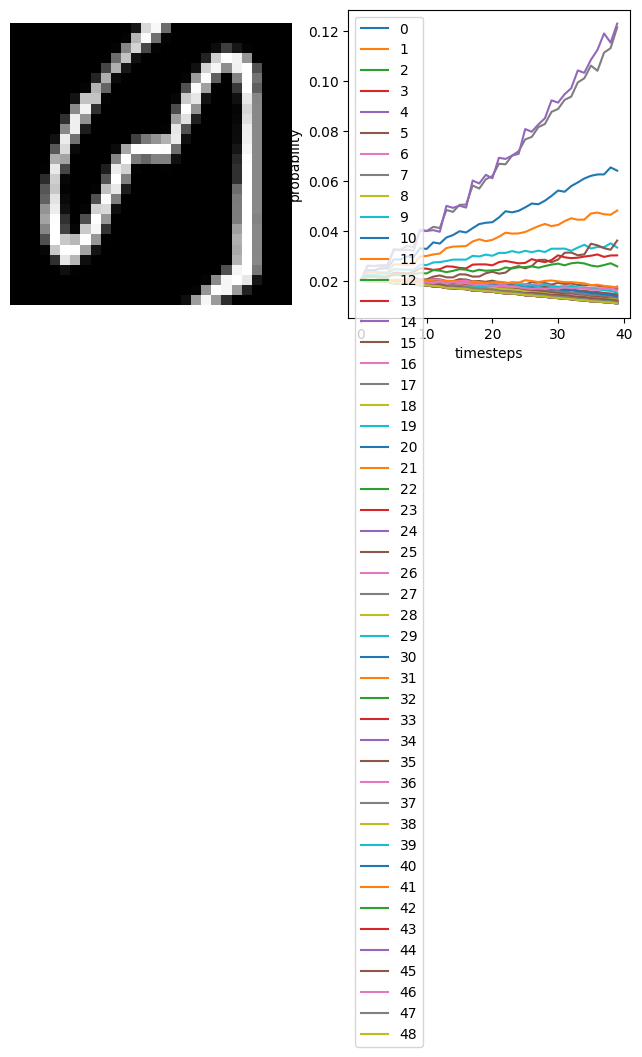

In [42]:
data = sim.predict(test_images[:256])

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[150 + i, 0].reshape((28, 28)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(tf.nn.softmax(data[out_p_filt][150 + i]))
    plt.legend([str(i) for i in range(49)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()